# exaSPIM example workflow

## Intro

This notebook provides a proof of principle for processing a exaSPIM dataset comprised of:
- 15 tiles (5x3 grid)
- 2 channels
- Full data size ~ 150 TB

The data is made available by the Allen Institute for Neural Dynamics and browseable via https://open.quiltdata.com/b/aind-open-data/tree/?prefix=exa.

## Setup

1. Setup Python in your preferred way (e.g. conda, venv, pipenv, poetry, etc.)
1. Make sure `multiview-stitcher >= 0.1.35` is installed: `pip install "multiview-stitcher>=0.1.35"`
1. Optionally, install `ray` for parallelising fusion on top of dask: `pip install "ray[default]"`

In [1]:
# imports

from pathlib import Path
import os
import dask.array as da
import numpy as np
import xarray as xr
import pandas as pd

import ngff_zarr
import pydantic_bigstitcher as pbs

from multiview_stitcher import spatial_image_utils as si_utils
from multiview_stitcher import (
    registration,
    fusion,
    param_utils,
    msi_utils,
    misc_utils,
    vis_utils,
    ngff_utils,
)

%matplotlib ipympl

## Define input paths

All data lives in the cloud in OME-Zarr format and we can directly access it via the web urls. Here we set the URLs.

In [2]:
bucket_url = "https://aind-open-data.s3.amazonaws.com"

base_path = "exaSPIM_674185_2023-10-02_14-06-36"
first_tile_path = "exaSPIM.zarr/tile_x_0000_y_0000_z_0000_ch_488.zarr"
metadata_path = "exaSPIM_acquisition.json"

# n_tiles_x = 5
# n_tiles_y = 3
n_tiles_x = 2
n_tiles_y = 1
channels = ["561"]

In [6]:

df = []
for ix in range(n_tiles_x):
    for iy in range(n_tiles_y):
        for ch in channels:
            # TODO: this could be cleaner
            tile_path = first_tile_path.replace("tile_x_0000_y_0000", f"tile_x_{ix:04d}_y_{iy:04d}")
            tile_path = tile_path.replace("ch_488", f"ch_{ch}")
            file_url = os.path.join(bucket_url, base_path, tile_path)
            print(f"Loading tile x={ix}, y={iy}, ch={ch}... filepath={tile_path}")
            msim = ngff_utils.ngff_multiscales_to_msim(
                ngff_zarr.from_ngff_zarr(file_url),
                transform_key='ome-zarr'
                )
            df.append({
                'ix': ix,
                'iy': iy,
                'filename': os.path.basename(tile_path),
                'file_url': file_url,
                'ch': ch,
                'msim': msim
                })

# combine everything into a dataframe
df = pd.DataFrame(df)
df

Loading tile x=0, y=0, ch=561... filepath=exaSPIM.zarr/tile_x_0000_y_0000_z_0000_ch_561.zarr
Loading tile x=1, y=0, ch=561... filepath=exaSPIM.zarr/tile_x_0001_y_0000_z_0000_ch_561.zarr


,ix,iy,filename,file_url,ch,msim
0,0,0,tile_x_0000_y_0000_z_0000_ch_561.zarr,https://aind-open-data.s3.amazonaws.com/exaSPI...,561,"[scale0, scale1, scale2, scale3, scale4, scale..."
1,1,0,tile_x_0001_y_0000_z_0000_ch_561.zarr,https://aind-open-data.s3.amazonaws.com/exaSPI...,561,"[scale0, scale1, scale2, scale3, scale4, scale..."


## Correct origins for multiscale data

The OME-Zarr files contain multiscale data. However, the origins of the different scales are not correctly set. We correct them here.

In [7]:
def correct_origins(msim):
    # # correct origins at each scale
    sks = msi_utils.get_sorted_scale_keys(msim)
    spacing0 = si_utils.get_spacing_from_sim(msi_utils.get_sim_from_msim(msim, sks[0]))
    origin0 = si_utils.get_origin_from_sim(msi_utils.get_sim_from_msim(msim, sks[0]))
    sdims = msi_utils.get_spatial_dims(msim)

    sim0 = msi_utils.get_sim_from_msim(msim, sks[0])
    shape0 = {dim: len(sim0.coords[dim]) for dim in sdims}
    msim = msim.map_over_datasets(lambda ds: xr.Dataset(
        {'image': ds.image.assign_coords(
            {dim: ds.image.coords[dim] - ds.image.coords[dim].values[0] + origin0[dim]\
              + (np.round(shape0[dim] / len(ds.image.coords[dim])) - 1) / 2 * spacing0[dim]
              for dim in sdims}
                )} | \
        {t: ds.data_vars[t] for t in ds.data_vars if t != 'image'})
        if len(ds.data_vars) > 0 else ds)

    return msim

df['msim'] = df['msim'].apply(lambda msim: correct_origins(msim))

## Visualize tile configuration

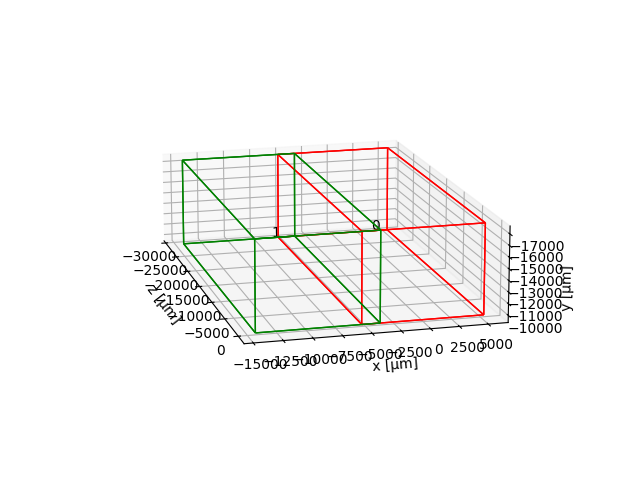

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='z [μm]', ylabel='x [μm]', zlabel='y [μm]'>)

In [9]:
# visualize the tile configuration and check it's properly set
from multiview_stitcher import vis_utils, msi_utils, fusion
vis_utils.plot_positions(
    df["msim"].tolist(), transform_key='ome-zarr'
)

In [11]:
import importlib
importlib.reload(vis_utils)

vis_utils.view_neuroglancer(
    df['file_url'].tolist(),
    sims=[msi_utils.get_sim_from_msim(msim) for msim in df['msim']],
    transform_key='ome-zarr',
    contrast_limits=(0, 150),
    single_layer=True,
)

Opening Neuroglancer in browser...
URL: https://neuroglancer-demo.appspot.com/#!%7B%22dimensions%22%3A%7B%22t%22%3A%5B1e-06%2C%22%22%5D%2C%22c%22%3A%5B1e-06%2C%22%22%5D%2C%22z%22%3A%5B1e-06%2C%22%22%5D%2C%22y%22%3A%5B7.479999743009102e-07%2C%22%22%5D%2C%22x%22%3A%5B7.480000148634645e-07%2C%22%22%5D%7D%2C%22displayDimensions%22%3A%5B%22x%22%2C%22y%22%2C%22z%22%5D%2C%22layerListPanel%22%3A%7B%22visible%22%3Atrue%7D%2C%22layout%22%3A%224panel%22%2C%22layers%22%3A%5B%7B%22source%22%3A%5B%7B%22url%22%3A%22https%3A//aind-open-data.s3.amazonaws.com/exaSPIM_674185_2023-10-02_14-06-36/exaSPIM.zarr/tile_x_0000_y_0000_z_0000_ch_561.zarr%22%2C%22transform%22%3A%7B%22matrix%22%3A%5B%5B1.0%2C0.0%2C0.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C1.0%2C0.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C1.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C0.0%2C1.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C0.0%2C0.0%2C1.0%2C0.0%5D%5D%2C%22outputDimensions%22%3A%7B%22t%22%3A%5B1e-06%2C%22%22%5D%2C%22c%27%22%3A%5B1e-06%2C%22%22%5D%2C%22z%22%3A%5

In [15]:
# print data sizes for the different scales
print("Data sizes for different scales (first tile):")
msim = df['msim'][0]
for scale in msim:
    print(f"Scale {scale}: {msim[scale].image.shape}")

Data sizes for different scales (first tile):
Scale scale0: (1, 1, 28672, 10640, 14192)
Scale scale1: (1, 1, 14336, 5320, 7096)
Scale scale2: (1, 1, 7168, 2660, 3548)
Scale scale3: (1, 1, 3584, 1330, 1774)
Scale scale4: (1, 1, 1792, 665, 887)
Scale scale5: (1, 1, 896, 333, 444)
Scale scale6: (1, 1, 448, 167, 222)


In [23]:
from multiview_stitcher import registration
import dask.diagnostics

with dask.diagnostics.ProgressBar():
    registration.register(
            df['msim'].tolist(),
            transform_key='ome-zarr',
            new_transform_key='phase_corr',
            reg_channel_index=0,
            # registration_binning={'z': 1, 'y': 1, 'x': 1},
            reg_res_level=5,
            n_parallel_pairwise_regs=5,
        )

[########################################] | 100% Completed | 936.07 ms
[########################################] | 100% Completed | 89.55 s


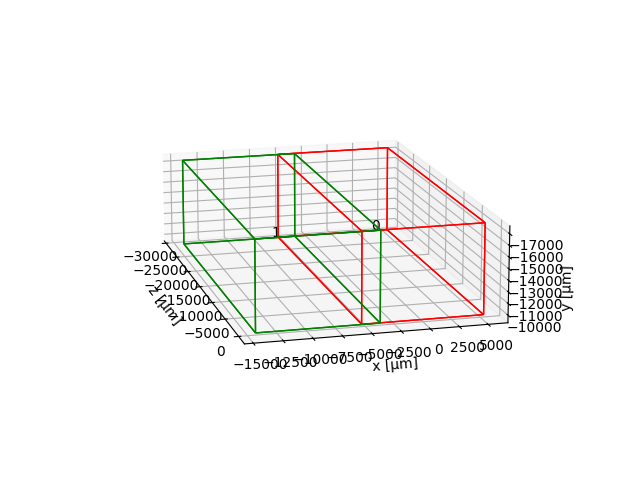

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='z [μm]', ylabel='x [μm]', zlabel='y [μm]'>)

In [24]:
# visualize obtained tile configuration after registration

vis_utils.plot_positions(
    df["msim"].tolist(), transform_key='phase_corr'
)

## Visualize segmentation result

In [ ]:
vis_utils.view_neuroglancer(
    df['file_url'].tolist(),
    sims=[msi_utils.get_sim_from_msim(msim) for msim in df['msim']],
    transform_key='phase_corr',
    single_layer=False, # setting this to true can improve neuroglancer performance
)

Opening Neuroglancer in browser...
URL: https://neuroglancer-demo.appspot.com/#!%7B%22dimensions%22%3A%7B%22t%22%3A%5B1e-06%2C%22%22%5D%2C%22c%22%3A%5B1e-06%2C%22%22%5D%2C%22z%22%3A%5B1e-06%2C%22%22%5D%2C%22y%22%3A%5B7.479999743009102e-07%2C%22%22%5D%2C%22x%22%3A%5B7.480000148634645e-07%2C%22%22%5D%7D%2C%22displayDimensions%22%3A%5B%22x%22%2C%22y%22%2C%22z%22%5D%2C%22layerListPanel%22%3A%7B%22visible%22%3Atrue%7D%2C%22layout%22%3A%224panel%22%2C%22layers%22%3A%5B%7B%22source%22%3A%7B%22url%22%3A%22https%3A//aind-open-data.s3.amazonaws.com/exaSPIM_674185_2023-10-02_14-06-36/exaSPIM.zarr/tile_x_0000_y_0000_z_0000_ch_561.zarr%22%2C%22transform%22%3A%7B%22matrix%22%3A%5B%5B1.0%2C0.0%2C0.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C1.0%2C0.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C1.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C0.0%2C1.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C0.0%2C0.0%2C1.0%2C0.0%5D%5D%2C%22outputDimensions%22%3A%7B%22t%22%3A%5B1e-06%2C%22%22%5D%2C%22c%27%22%3A%5B1e-06%2C%22%22%5D%2C%22z%22%3A%5B1e

## Fusion

We save the output to a (local) multiscale OME-Zarr file.

The progress bar gives an estimate of the processing time. Different scales can be used for fusion. Also different shapes and offsets can be specified for the output.

In [ ]:
# fusion_transform_key = 'ome-zarr'
fusion_transform_key = 'phase_corr'

msims = df['msim'].tolist()
sims = [msi_utils.get_sim_from_msim(
    msim,
    # scale='scale0', # set the scale to be used for fusion
    scale='scale5', # set the scale to be used for fusion
    )
    for msim in msims]

output_zarr_url = "fused_exa_0.zarr"

fused = fusion.fuse_to_multiscale_ome_zarr(
    fuse_kwargs={
        "sims": sims,
        "transform_key": fusion_transform_key,
        "output_chunksize": {dim: 256 for dim in ['z', 'y', 'x']},
        # "output_shape": {'z': 500, 'y': 500, 'x': 500}, # option to test smaller output
        "blending_widths": {"z": 1000, "y": 1000, "x": 1000},
    },
    output_zarr_url=output_zarr_url,
    batch_func_kwargs={
        'num_cpus': 8 # number of parallel processes to use
        },
    n_batch=8, # number of chunks to schedule for processing in parallel (typically set to the number of processes or a small multiple)
    batch_func=None,
    # batch_func=misc_utils.process_batch_using_ray, # we can use ray for parallelising on top of dask (`pip install "ray[default]"`)
)

Fusing 32 blocks in batches of 8...


100%|██████████| 4/4 [01:40<00:00, 25.20s/it]


## Visualize the fused dataset

In [28]:
# interrupt the notebook cell to stop the viewer
vis_utils.view_neuroglancer(
    sims=[fused],
    ome_zarr_paths=[output_zarr_url],
    channel_coord=0,
    transform_key="phase_corr",
)

Opening Neuroglancer in browser...
URL: https://neuroglancer-demo.appspot.com/#!%7B%22dimensions%22%3A%7B%22t%22%3A%5B1e-06%2C%22%22%5D%2C%22c%22%3A%5B1e-06%2C%22%22%5D%2C%22z%22%3A%5B3.2e-05%2C%22%22%5D%2C%22y%22%3A%5B2.3935999177629128e-05%2C%22%22%5D%2C%22x%22%3A%5B2.3936000475619946e-05%2C%22%22%5D%7D%2C%22displayDimensions%22%3A%5B%22x%22%2C%22y%22%2C%22z%22%5D%2C%22layerListPanel%22%3A%7B%22visible%22%3Atrue%7D%2C%22layout%22%3A%224panel%22%2C%22layers%22%3A%5B%7B%22source%22%3A%7B%22url%22%3A%22http%3A//localhost%3A8000/fused_exa_0.zarr%22%2C%22transform%22%3A%7B%22matrix%22%3A%5B%5B1.0%2C0.0%2C0.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C1.0%2C0.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C1.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C0.0%2C1.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C0.0%2C0.0%2C1.0%2C0.0%5D%5D%2C%22outputDimensions%22%3A%7B%22t%22%3A%5B1e-06%2C%22%22%5D%2C%22c%27%22%3A%5B1e-06%2C%22%22%5D%2C%22z%22%3A%5B3.2e-05%2C%22%22%5D%2C%22y%22%3A%5B2.3935999177629128e-05%2C%22%22%5D%2C%22x%22%3A%

::1 - - [14/Oct/2025 11:39:45] "HEAD /fused_exa_0.zarr HTTP/1.1" 301 -
::1 - - [14/Oct/2025 11:39:45] "HEAD /fused_exa_0.zarr/ HTTP/1.1" 200 -
::1 - - [14/Oct/2025 11:39:45] code 404, message File not found
::1 - - [14/Oct/2025 11:39:45] "HEAD /fused_exa_0.zarr/refs/branch.main/ZZZZZZZZ.json HTTP/1.1" 404 -
::1 - - [14/Oct/2025 11:39:45] code 404, message File not found
::1 - - [14/Oct/2025 11:39:45] "HEAD /fused_exa_0.zarr/manifest.ocdbt HTTP/1.1" 404 -
::1 - - [14/Oct/2025 11:39:45] code 404, message File not found
::1 - - [14/Oct/2025 11:39:45] "HEAD /fused_exa_0.zarr/attributes.json HTTP/1.1" 404 -
::1 - - [14/Oct/2025 11:39:45] code 404, message File not found
::1 - - [14/Oct/2025 11:39:45] "HEAD /fused_exa_0.zarr/info HTTP/1.1" 404 -
::1 - - [14/Oct/2025 11:39:45] code 404, message File not found
::1 - - [14/Oct/2025 11:39:45] "HEAD /fused_exa_0.zarr/.zarray HTTP/1.1" 404 -
::1 - - [14/Oct/2025 11:39:45] "HEAD /fused_exa_0.zarr/.zattrs HTTP/1.1" 200 -
::1 - - [14/Oct/2025 11:39:4


Keyboard interrupt received, exiting.


SystemExit: 0

/Users/albertm/.pixi/envs/conda/envs/ms/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [11]:
from multiview_stitcher import fusion

fusion_transform_key = 'ome-zarr'
# fusion_transform_key = 'phase_corr'

dfcif = df.groupby(lambda _: 0)['msim'].apply(
    lambda x: fusion.fuse(
        [msi_utils.get_sim_from_msim(msim, scale='scale0') for msim in x][:],
        transform_key=fusion_transform_key,
        output_chunksize={'z': 512, 'y': 512, 'x': 512},
        blending_widths={"z": 1000, "y": 1000, "x": 1000},
        )
).reset_index()
dfcif['msim'].iloc[0]

<xarray.DataArray 'image' (t: 1, c: 1, z: 3584, y: 3592, x: 7806)> Size: 201GB
dask.array<getitem, shape=(1, 1, 3584, 3592, 7806), dtype=uint16, chunksize=(1, 1, 512, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * t        (t) int64 8B 0
  * c        (c) int64 8B 0
  * z        (z) float64 29kB -2.867e+04 -2.866e+04 -2.866e+04 ... -16.0 -8.0
  * y        (y) float64 29kB -1.751e+04 -1.75e+04 ... 3.973e+03 3.979e+03
  * x        (x) float64 62kB -4.14e+04 -4.139e+04 ... 5.298e+03 5.304e+03
Attributes:
    transforms:  {'ome-zarr': <xarray.DataArray (x_in: 4, x_out: 4)> Size: 12...

In [13]:
import os
import dask.diagnostics

# output_dir = Path('/Users/albertm/software/multiview-stitcher/_playground/exa_spim/fused')
output_dir = Path('/Volumes/scuanalysis/SCU/Marvin/multiview-stitcher/exa_fused')

if not output_dir.parent.exists():
    output_dir.parent.mkdir(parents=True, exist_ok=True)
output_filename = os.path.join(output_dir, 'fused.zarr')

print(f'Fusing views and saving output to {output_filename}...')
with dask.diagnostics.ProgressBar():
    fused = ngff_utils.write_sim_to_ome_zarr(
        dfcif.iloc[0]['msim'], output_filename, overwrite=True
    )


Fusing views and saving output to /Volumes/scuanalysis/SCU/Marvin/multiview-stitcher/exa_fused/fused.zarr...


/Users/albertm/.pixi/envs/conda/envs/ms/lib/python3.11/site-packages/zarr/api/asynchronous.py:1257: ZarrRuntimeWarning: The `write_empty_chunks` keyword argument is deprecated and will be removed in future versions. To control whether empty chunks are written to storage, either use the `config` keyword argument, as in `config={'write_empty_chunks': True}`,or change the global 'array.write_empty_chunks' configuration variable.
  _warn_write_empty_chunks_kwarg()
/Users/albertm/.pixi/envs/conda/envs/ms/lib/python3.11/site-packages/zarr/api/asynchronous.py:1036: ZarrRuntimeWarning: The `write_empty_chunks` keyword argument is deprecated and will be removed in future versions. To control whether empty chunks are written to storage, either use the `config` keyword argument, as in `config={'write_empty_chunks': True}`,or change the global 'array.write_empty_chunks' configuration variable.
  _warn_write_empty_chunks_kwarg()


[#                                       ] | 3% Completed | 15m 18sss


TimeoutError: 

In [14]:
# interrupt the notebook cell to stop the viewer
vis_utils.view_neuroglancer(
    sims=[fused],
    ome_zarr_paths=[output_filename],
    channel_coord=0,
    transform_key=fusion_transform_key,
)

FileNotFoundError: /Volumes/scuanalysis/SCU/Marvin/multiview-stitcher/exa_fused/fused.zarr does not exist

In [ ]:
# # interrupt the notebook cell to stop the viewer
# vis_utils.view_neuroglancer(
#     sims=[msi_utils.get_sim_from_msim(msim) for msim in df['msim']] + [fused],
#     ome_zarr_paths=df['file_url'].tolist() + [output_filename],
#     # channel_coord=0,
#     transform_key=fusion_transform_key,
# )

DEBUG:fsspec.http:https://aind-open-data.s3.amazonaws.com/exaSPIM_678794_2024-03-18_12-35-52/SPIM.ome.zarr/tile_x_0003_y_0001_z_0000_ch_561.zarr/zarr.json
DEBUG:fsspec.http:https://aind-open-data.s3.amazonaws.com/exaSPIM_678794_2024-03-18_12-35-52/SPIM.ome.zarr/tile_x_0003_y_0001_z_0000_ch_561.zarr/.zgroup
DEBUG:fsspec.http:https://aind-open-data.s3.amazonaws.com/exaSPIM_678794_2024-03-18_12-35-52/SPIM.ome.zarr/tile_x_0003_y_0001_z_0000_ch_561.zarr/.zattrs
DEBUG:fsspec.http:https://aind-open-data.s3.amazonaws.com/exaSPIM_678794_2024-03-18_12-35-52/SPIM.ome.zarr/tile_x_0003_y_0001_z_0000_ch_561.zarr/.zmetadata
DEBUG:fsspec.http:https://aind-open-data.s3.amazonaws.com/exaSPIM_678794_2024-03-18_12-35-52/SPIM.ome.zarr/tile_x_0003_y_0001_z_0000_ch_561.zarr/0/zarr.json
DEBUG:fsspec.http:https://aind-open-data.s3.amazonaws.com/exaSPIM_678794_2024-03-18_12-35-52/SPIM.ome.zarr/tile_x_0003_y_0001_z_0000_ch_561.zarr/0/.zarray
DEBUG:fsspec.http:https://aind-open-data.s3.amazonaws.com/exaSPIM_67879

Opening Neuroglancer in browser...
URL: https://neuroglancer-demo.appspot.com/#!%7B%22dimensions%22%3A%7B%22t%22%3A%5B1e-06%2C%22%22%5D%2C%22c%22%3A%5B1e-06%2C%22%22%5D%2C%22z%22%3A%5B8e-06%2C%22%22%5D%2C%22y%22%3A%5B5.984000345100867e-06%2C%22%22%5D%2C%22x%22%3A%5B5.983999568419676e-06%2C%22%22%5D%7D%2C%22displayDimensions%22%3A%5B%22x%22%2C%22y%22%2C%22z%22%5D%2C%22layerListPanel%22%3A%7B%22visible%22%3Atrue%7D%2C%22layout%22%3A%224panel%22%2C%22layers%22%3A%5B%7B%22source%22%3A%7B%22url%22%3A%22https%3A//aind-open-data.s3.amazonaws.com/exaSPIM_678794_2024-03-18_12-35-52/SPIM.ome.zarr/tile_x_0003_y_0001_z_0000_ch_561.zarr%22%2C%22transform%22%3A%7B%22matrix%22%3A%5B%5B1.0%2C0.0%2C0.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C1.0%2C0.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C1.0%2C0.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C0.0%2C1.0%2C0.0%2C0.0%5D%2C%5B0.0%2C0.0%2C0.0%2C0.0%2C1.0%2C0.0%5D%5D%2C%22outputDimensions%22%3A%7B%22t%22%3A%5B1e-06%2C%22%22%5D%2C%22c%27%22%3A%5B1e-06%2C%22%22%5D%2C%22z%22%3A%5B8

::1 - - [08/Oct/2025 21:55:15] "HEAD /fused.zarr HTTP/1.1" 301 -
::1 - - [08/Oct/2025 21:55:15] "HEAD /fused.zarr/ HTTP/1.1" 200 -
::1 - - [08/Oct/2025 21:55:15] code 404, message File not found
::1 - - [08/Oct/2025 21:55:15] "HEAD /fused.zarr/refs/branch.main/ZZZZZZZZ.json HTTP/1.1" 404 -
::1 - - [08/Oct/2025 21:55:15] code 404, message File not found
::1 - - [08/Oct/2025 21:55:15] "HEAD /fused.zarr/manifest.ocdbt HTTP/1.1" 404 -
::1 - - [08/Oct/2025 21:55:15] code 404, message File not found
::1 - - [08/Oct/2025 21:55:15] "HEAD /fused.zarr/attributes.json HTTP/1.1" 404 -
::1 - - [08/Oct/2025 21:55:15] code 404, message File not found
::1 - - [08/Oct/2025 21:55:15] "HEAD /fused.zarr/info HTTP/1.1" 404 -
::1 - - [08/Oct/2025 21:55:15] code 404, message File not found
::1 - - [08/Oct/2025 21:55:15] "HEAD /fused.zarr/.zarray HTTP/1.1" 404 -
::1 - - [08/Oct/2025 21:55:15] code 404, message File not found
::1 - - [08/Oct/2025 21:55:15] "HEAD /fused.zarr/.zattrs HTTP/1.1" 404 -
::1 - - [08/


Keyboard interrupt received, exiting.


SystemExit: 0

/Users/albertm/.pixi/envs/conda/envs/ms/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
